MARASIGAN, Geremiah Zachary <b>11610611</b><br>
ONA, Ian <b>11614854</b>

In [83]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import scipy
from scipy import stats
import seaborn as sns
import geopandas as gpd
import math
sns.set()

from pathlib import Path

# The Philippines Under Fire
## Data Science Project using Fire Incident Open Data
In this project, we plan to ...

## Preparing our Data

In [84]:
# First, we prepare our main dataset, BFP Fire Incidents
DSDATA = Path(os.getenv('DSDATA'))
file = DSDATA / 'BFP_FIreIncidents2012-2016.csv'
if file.exists():
    print('File exists!')
else:
    print('Please download file and place insisde DSDATA folder.')

File exists!


In [85]:
df = pd.read_csv(file, encoding='latin-1')
# Title case our provinces for easier merging with map later on
df['PROVINCE_FIRE_DISTRICT'] = df['PROVINCE_FIRE_DISTRICT'].apply(lambda x: x.title())

# Check for any null values
df.isnull().values.any()

# No need to handle null values since none exist

False

In [86]:
# Column names for reference
print("FIRE DATA COLUMN NAMES")
list(df)

# Since all column names are already descriptive and properly formatted, no need to clean

FIRE DATA COLUMN NAMES


['PSGC',
 'REGION',
 'PROVINCE_FIRE_DISTRICT',
 'CONGRESSIONAL_DISTRICT',
 'CITY_MUNICIPALITY',
 'YEAR',
 'INCIDENTS',
 'INJURIES',
 'DEATHS',
 'ESTIMATED_DAMAGES']

In [87]:
# Column datatypes for reference
print("FIRE DATA COLUMN TYPES")
for col in df.columns:
  print(col + " : " + str(df[col].dtype))
 
# Since all data types are appropriate for each column, no need to clean

FIRE DATA COLUMN TYPES
PSGC : int64
REGION : object
PROVINCE_FIRE_DISTRICT : object
CONGRESSIONAL_DISTRICT : object
CITY_MUNICIPALITY : object
YEAR : int64
INCIDENTS : int64
INJURIES : int64
DEATHS : int64
ESTIMATED_DAMAGES : float64


In [88]:
# Next, we prepare supplemetary datasets (BFP Firetrucks & Internal Revenue Allotment)
ira_file = DSDATA / '2009-2014_irad_by_province.csv'
firetrucks_file = DSDATA / 'bfp_firetrucks.csv'
if ira_file.exists() and firetrucks_file.exists():
    print('Files exists!')
else:
    print('Please download files and place insisde DSDATA folder.')

Files exists!


In [89]:
df2 = pd.read_csv(firetrucks_file, encoding='latin-1')

# Capitalize column names for uniformity
df2.columns = [col.upper() for col in df2.columns]

# Title case our provinces for easier merging with map later on
df2['PROVINCE'] = df2['PROVINCE'].apply(lambda x: x.title())

df2.isnull().values.any()
# No null data for now, but we will check again later after cleaning

False

In [90]:
# Column names for reference
print("FIRETRUCK COLUMN NAMES")
list(df2)

# Since all column names are already descriptive and properly formatted, no need to clean

FIRETRUCK COLUMN NAMES


['TRUCK_ID',
 'REGION',
 'PROVINCE',
 'CONGRESSIONAL_DISTRICT',
 'CITY_OR_MUNICIPALITY',
 'STATION_NAME',
 'VEHICLE_MODEL',
 'VEHICLE_TYPE',
 'VEHICLE_CAPACITY',
 'VEHICLE_STATUS',
 'VEHICLE_OWNER',
 'PLATE_NUMBER',
 'ENGINE_NUMBER',
 'CHASSIS_NUMBER',
 'ACQUISITION_COST',
 'MANUFACTURE_DATE',
 'MANUFACTURE_AGE',
 'ACQUISITION_DATE',
 'ACQUISITION_AGE',
 'REMARKS']

In [91]:
# Fix incorrect data types
df2['VEHICLE_CAPACITY'] = pd.to_numeric(df2['VEHICLE_CAPACITY'], errors='coerce', downcast='integer')
df2['MANUFACTURE_DATE'] = pd.to_numeric(df2['MANUFACTURE_DATE'], errors='coerce', downcast='integer')
df2['MANUFACTURE_AGE'] = pd.to_numeric(df2['MANUFACTURE_AGE'], errors='coerce', downcast='integer')
df2['ACQUISITION_DATE'] = pd.to_numeric(df2['ACQUISITION_DATE'], errors='coerce', downcast='integer')
df2['ACQUISITION_AGE'] = pd.to_numeric(df2['ACQUISITION_AGE'], errors='coerce', downcast='integer')
if df2['ACQUISITION_COST'].dtype != "float64":
    df2['ACQUISITION_COST'] = df2['ACQUISITION_COST'].str.replace('PhP', '')
    df2['ACQUISITION_COST'] = df2['ACQUISITION_COST'].str.replace(',', '')
    df2['ACQUISITION_COST'] = pd.to_numeric(df2['ACQUISITION_COST'], errors='coerce')

# Column datatypes for reference
print("FIRETRUCK COLUMN DATA TYPES")
for col in df2.columns:
    print(col + " : " + str(df2[col].dtype))

# Since there are null values now, we have to handle them
df2.fillna(0, inplace=True)

FIRETRUCK COLUMN DATA TYPES
TRUCK_ID : int64
REGION : object
PROVINCE : object
CONGRESSIONAL_DISTRICT : object
CITY_OR_MUNICIPALITY : object
STATION_NAME : object
VEHICLE_MODEL : object
VEHICLE_TYPE : object
VEHICLE_CAPACITY : float64
VEHICLE_STATUS : object
VEHICLE_OWNER : object
PLATE_NUMBER : object
ENGINE_NUMBER : object
CHASSIS_NUMBER : object
ACQUISITION_COST : float64
MANUFACTURE_DATE : float64
MANUFACTURE_AGE : float64
ACQUISITION_DATE : float64
ACQUISITION_AGE : float64
REMARKS : object


In [92]:
df3 = pd.read_csv(ira_file, encoding='latin-1')

# Capitalize column names for uniformity
df3.columns = [col.upper() for col in df3.columns]

# Title case our provinces for easier merging with map later on
# df2['PROVINCE'] = df2['PROVINCE'].apply(lambda x: x.title())

df3.isnull().values.any()
# No null data for now, but we will check again later after cleaning

False

In [93]:
# Column names for reference
print("IRA COLUMN NAMES")
list(df3)

# Since all column names are already descriptive and properly formatted, no need to clean

IRA COLUMN NAMES


['REGION', 'PROVINCE', '2009', '2010', '2011', '2012', '2013', '2014']

In [94]:
# Fix incorrect data types
df3['2013'] = pd.to_numeric(df3['2013'], errors='coerce', downcast='integer')
df3['2013'].fillna(0, inplace = True)
df3['2013'] = pd.Series(df3['2013']).astype(int)
# Column datatypes for reference
print("IRA COLUMN DATA TYPES")
for col in df3.columns:
    print(col + " : " + str(df3[col].dtype))

IRA COLUMN DATA TYPES
REGION : object
PROVINCE : object
2009 : int64
2010 : int64
2011 : int64
2012 : int64
2013 : int64
2014 : int64


## Preliminary Visualizations and Descriptive Statistics
For initial visualizations we will first be visualizing the distribution of the dataset on the values for Incidents, Injuries, and Deaths. We will also be visualizing the mean number of incidents by region to provide insight on which region experiences the most fire incidents on average.

In [95]:
# How to do all 3 in one? (subplot)

# sns.distplot(df1["DEATHS"]);
sns.distplot(df["INCIDENTS"])
# sns.distplot(df1["ESTIMATED_DAMAGES"]);

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


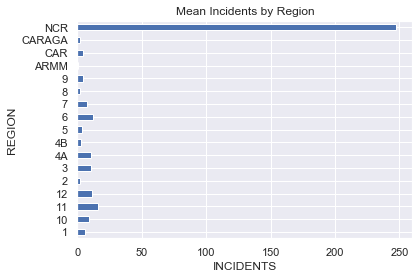

In [112]:
# Visualize mean number of incidents per region
group_category = df.groupby('REGION')['INCIDENTS'].apply(lambda x: x.mean())
group_category.plot.barh()
plt.title('Mean Incidents by Region')
plt.xlabel("INCIDENTS")
plt.ylabel("REGION")

plt.show()

# To do: more descriptive stats and visualizaions to provide insight on our data (can also use the other datasets we plan to use)

## Map Visualizations
To provide more comprehensive insight on which areas are affected the most by fire incidents, the following visualizations will consist of geospatial information as to easier pinpoint our areas of interest.

In [97]:
# Load shape file for the Philippine map
ph = gpd.read_file(DSDATA / 'gadm36_PHL_shp/gadm36_PHL_2.shp')
ph['NAME_1'].unique()
ph = ph[['NAME_1','geometry']]
ph.head()

,NAME_1,geometry
0,Abra,"POLYGON ((120.62709808 17.49300003, 120.621772..."
1,Abra,"POLYGON ((120.99041748 17.39801979, 120.986312..."
2,Abra,"POLYGON ((120.70787811 17.45395088, 120.706207..."
3,Abra,"POLYGON ((120.78955841 17.41699028, 120.789222..."
4,Abra,"POLYGON ((120.9291687 17.41307068, 120.9246368..."


In [98]:
# Since the dataset we are working with is aggregated by provincial fire district,
# we want to aggregate our map by province as well
ph_by_province = ph.dissolve(by='NAME_1', aggfunc='sum')
ph_by_province.head()

,geometry
NAME_1,
Abra,"POLYGON ((120.77472687 17.1631794, 120.7663726..."
Agusan del Norte,"POLYGON ((125.4462738 8.66631031, 125.44199371..."
Agusan del Sur,"POLYGON ((126.04052734 7.93676996, 126.0383834..."
Aklan,"(POLYGON ((122.4366684 11.59832954, 122.436668..."
Albay,"(POLYGON ((123.28764343 13.04922962, 123.28685..."


In [99]:
# We want to find discrepancies in the province list before we merge the fire incidents into the map
# To do that, we find elements in both lists that are unique and see what we can do
provinces_df = df['PROVINCE_FIRE_DISTRICT'].tolist()
provinces_map = ph['NAME_1'].unique().tolist()
tofix = list(set(provinces_map)-set(provinces_df)) + ["/////"] + list(set(provinces_df)-set(provinces_map))
print(tofix)

# Findings:
# We can merge cases like Agusan del Norte and Agusan Del Norte (they differ in one character)
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Zamboanga Del Sur', 'PROVINCE_FIRE_DISTRICT'] = 'Zamboanga del Sur'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Zamboanga Del Norte', 'PROVINCE_FIRE_DISTRICT'] = 'Zamboanga del Norte'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Agusan Del Sur', 'PROVINCE_FIRE_DISTRICT'] = 'Agusan del Sur'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Agusan Del Norte', 'PROVINCE_FIRE_DISTRICT'] = 'Agusan del Norte'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Lanao Del Sur', 'PROVINCE_FIRE_DISTRICT'] = 'Lanao del Sur'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Lanao Del Norte', 'PROVINCE_FIRE_DISTRICT'] = 'Lanao del Norte'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Davao Del Sur', 'PROVINCE_FIRE_DISTRICT'] = 'Davao del Sur'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Davao Del Norte', 'PROVINCE_FIRE_DISTRICT'] = 'Davao del Norte'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Surigao Del Sur', 'PROVINCE_FIRE_DISTRICT'] = 'Surigao del Sur'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Surigao Del Norte', 'PROVINCE_FIRE_DISTRICT'] = 'Surigao del Norte'
# We can map all Districts (from the BFP dataset) to Metropolitan Manila (in the map) as they pertain to
# different districts within NCR
df.loc[df['PROVINCE_FIRE_DISTRICT'].str.contains('District'), 'PROVINCE_FIRE_DISTRICT'] = 'Metropolitan Manila'
# We can merge cases such as North Cotabato and Cotabato (North Cotabato)
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Cotabato (North Cotabato)', 'PROVINCE_FIRE_DISTRICT'] = 'North Cotabato'
df.loc[df['PROVINCE_FIRE_DISTRICT'] == 'Samar (Western Samar)', 'PROVINCE_FIRE_DISTRICT'] = 'Samar'

provinces_df = df['PROVINCE_FIRE_DISTRICT'].tolist()
provinces_map = ph['NAME_1'].unique().tolist()
tofix = list(set(provinces_map)-set(provinces_df)) + ["/////"] + list(set(provinces_df)-set(provinces_map))
print(tofix)

['Metropolitan Manila', 'Surigao del Sur', 'Lanao del Sur', 'Agusan del Sur', 'North Cotabato', 'Samar', 'Zamboanga del Sur', 'Zamboanga del Norte', 'Davao del Norte', 'Lanao del Norte', 'Surigao del Norte', 'Davao del Sur', 'Agusan del Norte', '/////', 'District Ii', 'Davao Occidental', 'Surigao Del Norte', 'Davao Del Norte', 'District Iv', 'District Iii', 'District V', 'Davao Del Sur', 'Lanao Del Norte', 'Surigao Del Sur', 'Zamboanga Del Sur', 'Cotabato (North Cotabato)', 'Agusan Del Norte', 'Lanao Del Sur', 'Zamboanga Del Norte', 'Samar (Western Samar)', 'District I', 'Agusan Del Sur']
['/////', 'Davao Occidental']


In [100]:
# We want to visualize the data for 2016 first
df_2016 = df.loc[df['YEAR'] == 2016]
df_2016 = df_2016.groupby('PROVINCE_FIRE_DISTRICT').aggregate({'INCIDENTS':'sum',
                                                               'INJURIES':'sum',
                                                               'DEATHS':'sum',
                                                               'ESTIMATED_DAMAGES':'sum'})
df_2016.reset_index(level=0, inplace=True)

# Since we fixed the names of the provinces in the dataframe, they can now be used as basis for merging
merged = ph_by_province.merge(df_2016,left_on='NAME_1',right_on='PROVINCE_FIRE_DISTRICT')

# Metro Manila fire stats is way higher than anywhere else, uncomment the line below to drop it and 
# visualize the other places in comparison with each other because the way it is now, it just looks
# like Metro Manila is the only place of interest (kinda like an outlier)
# merged = merged.drop(46)

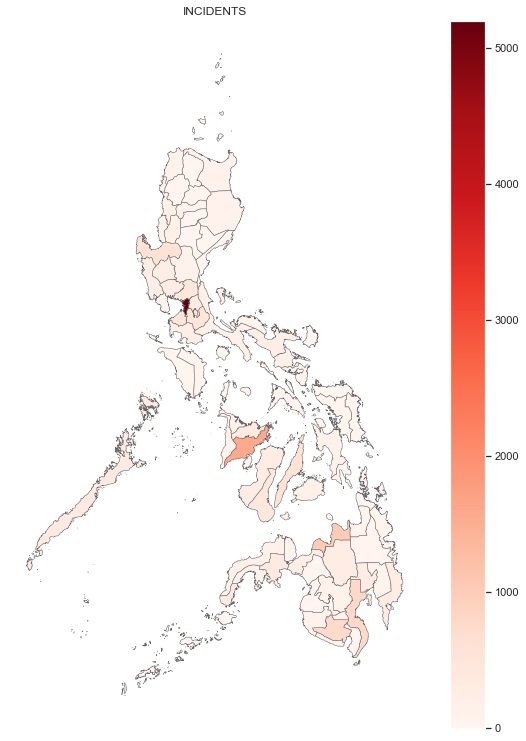

In [101]:
# We can plot now that the data is merged into the map
# First, we explore number of incidents throughout the country
fig, ax= plt.subplots(1,figsize=(10, 13))
variable = 'INCIDENTS'
vmin, vmax = 0, int(math.ceil((merged[variable].max()) / 100.0)) * 100
merged.plot(column=variable, cmap='Reds', linewidth=0.5, ax=ax, edgecolor='0.4')
ax.axis('off')
ax.set_title(variable)

sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
plt.show()

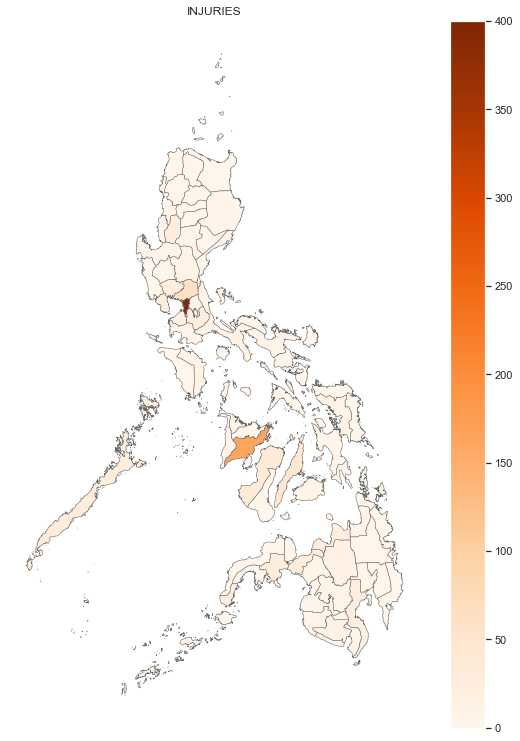

In [102]:
# Next, we visualize the injuries due to fire incidents
fig, ax= plt.subplots(1,figsize=(10, 13))

variable = 'INJURIES'
vmin, vmax = 0, int(math.ceil((merged[variable].max()) / 100.0)) * 100
merged.plot(column=variable, cmap='Oranges', linewidth=0.5, ax=ax, edgecolor='0.4')
ax.axis('off')
ax.set_title(variable)

sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
plt.show()

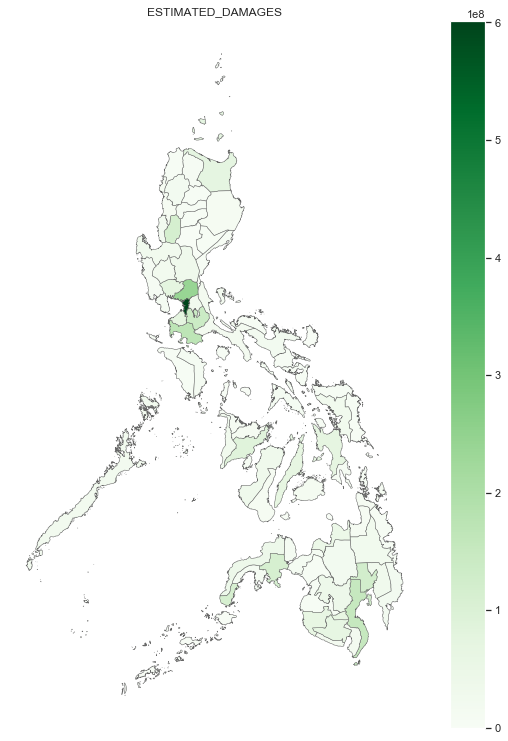

In [103]:
# Lastly, we visualize the estimated damages
fig, ax= plt.subplots(1,figsize=(10, 13))

variable = 'ESTIMATED_DAMAGES'
vmin, vmax = 0, int(math.ceil((merged[variable].max()) / 100.0)) * 100
merged.plot(column=variable, cmap='Greens', linewidth=0.5, ax=ax, edgecolor='0.4')
ax.axis('off')
ax.set_title(variable)

sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
plt.show()

## Identifying Possible Correlations
Next, we will be trying to find variables that have possible correlations. We will be using scatter plots to determine possible correlations within the Fire Incidents dataset. We will also be cross referencing other datasets such as the Internal Revenue Allotment and BFP Firetruck Information to determine possible correlations between fire incidents and local government budget as well as fire incidents and fire truck placement.

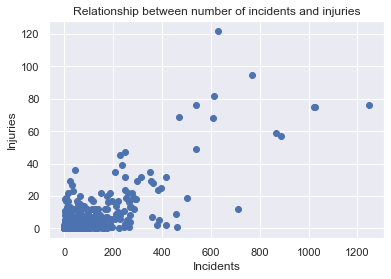

In [104]:
# Scatter plot of injuries vs incidents
plt.scatter(df.INCIDENTS, df['INJURIES'])
plt.title('Relationship between number of incidents and injuries')
plt.xlabel("Incidents")
plt.ylabel("Injuries")
plt.show()
# To do: more scatter plots, include other datasets

### Findings (Initial Scatterplots)
Lorem ipsum

In [105]:
# Before merging fire truck dataset with df_2016, we must fix the naming for the provinces
provinces_df = df['PROVINCE_FIRE_DISTRICT'].tolist()
provinces_df2 = df2['PROVINCE'].unique().tolist()
tofix = list(set(provinces_df2)-set(provinces_df)) + ["/////"] + list(set(provinces_df)-set(provinces_df2))
print(tofix)

# Findings:
# We can merge cases like Agusan del Norte and Agusan Del Norte (they differ in one character)
df2.loc[df2['PROVINCE'] == 'Zamboanga Del Sur', 'PROVINCE'] = 'Zamboanga del Sur'
df2.loc[df2['PROVINCE'] == 'Zamboanga Del Norte', 'PROVINCE'] = 'Zamboanga del Norte'
df2.loc[df2['PROVINCE'] == 'Agusan Del Sur', 'PROVINCE'] = 'Agusan del Sur'
df2.loc[df2['PROVINCE'] == 'Agusan Del Norte', 'PROVINCE'] = 'Agusan del Norte'
df2.loc[df2['PROVINCE'] == 'Lanao Del Sur', 'PROVINCE'] = 'Lanao del Sur'
df2.loc[df2['PROVINCE'] == 'Lanao Del Norte', 'PROVINCE'] = 'Lanao del Norte'
df2.loc[df2['PROVINCE'] == 'Davao Del Sur', 'PROVINCE'] = 'Davao del Sur'
df2.loc[df2['PROVINCE'] == 'Davao Del Norte', 'PROVINCE'] = 'Davao del Norte'
df2.loc[df2['PROVINCE'] == 'Surigao Del Sur', 'PROVINCE'] = 'Surigao del Sur'
df2.loc[df2['PROVINCE'] == 'Surigao Del Norte', 'PROVINCE'] = 'Surigao del Norte'
# We can map all Districts (from the BFP dataset) to Metropolitan Manila (in the map) as they pertain to
# different districts within NCR
df2.loc[df2['PROVINCE'].str.contains('District'), 'PROVINCE'] = 'Metropolitan Manila'
# We can merge cases such as North Cotabato and Cotabato (North Cotabato)
df2.loc[df2['PROVINCE'] == 'Cotabato (North Cotabato)', 'PROVINCE'] = 'North Cotabato'
df2.loc[df2['PROVINCE'] == 'Samar (Western Samar)', 'PROVINCE'] = 'Samar'

provinces_df = df['PROVINCE_FIRE_DISTRICT'].tolist()
provinces_df2 = df2['PROVINCE'].unique().tolist()
tofix = list(set(provinces_df2)-set(provinces_df)) + ["/////"] + list(set(provinces_df)-set(provinces_df2))
print(tofix)

['District Ii', 'Surigao Del Norte', 'Davao Del Norte', 'District Iv', 'District Iii', 'District V', 'Davao Del Sur', 'Lanao Del Norte', 'Surigao Del Sur', 'Zamboanga Del Sur', 'Cotabato (North Cotabato)', 'Agusan Del Norte', 'Lanao Del Sur', 'Zamboanga Del Norte', 'Samar (Western Samar)', 'District I', 'Agusan Del Sur', '/////', 'Metropolitan Manila', 'Surigao del Sur', 'Lanao del Sur', 'Agusan del Sur', 'North Cotabato', 'Samar', 'Zamboanga del Sur', 'Zamboanga del Norte', 'Davao del Norte', 'Lanao del Norte', 'Surigao del Norte', 'Davao del Sur', 'Agusan del Norte']
['/////']


In [106]:
# Next, we aggregate the firetruck dataset by province
df2_aggregated = df2.groupby('PROVINCE').aggregate({'VEHICLE_MODEL':'count',
                                                    'VEHICLE_CAPACITY':'mean',
                                                    'ACQUISITION_COST':'mean',
                                                    'ACQUISITION_AGE':'mean'})
df2_aggregated = df2_aggregated.rename({'VEHICLE_MODEL':'VEHICLES'},axis=1)
df2_aggregated.reset_index(level=0, inplace=True)
df2_aggregated.head()

,PROVINCE,VEHICLES,VEHICLE_CAPACITY,ACQUISITION_COST,ACQUISITION_AGE
0,Abra,14,750.000000,3.932930e+06,10.000000
1,Agusan del Norte,25,1062.840000,2.528771e+06,17.920000
2,Agusan del Sur,26,899.961538,2.458881e+06,9.153846
3,Aklan,18,819.444444,2.563025e+06,17.388889
4,Albay,34,1014.705882,4.025598e+06,17.647059


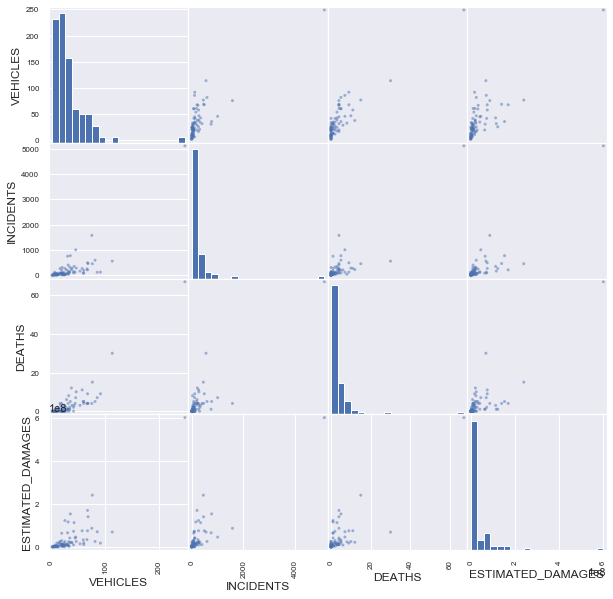

In [107]:
# Now we can merge the firetruck dataset with the fire incident data from 2016
merged_firetruck = df_2016.merge(df2_aggregated,left_on='PROVINCE_FIRE_DISTRICT',right_on='PROVINCE')

# We now use scatterplot visualizations to observe possible correlations between 
# number, age, cost of fire trucks with fire incident statistics

# First, we look at the relation of the number of firetruck to fire incident statistics
pd.plotting.scatter_matrix(merged_firetruck[['VEHICLES', 'INCIDENTS', 'DEATHS', 'ESTIMATED_DAMAGES']],
                           alpha=0.5, figsize=(10,10), hist_kwds={'bins': 20})
plt.show()

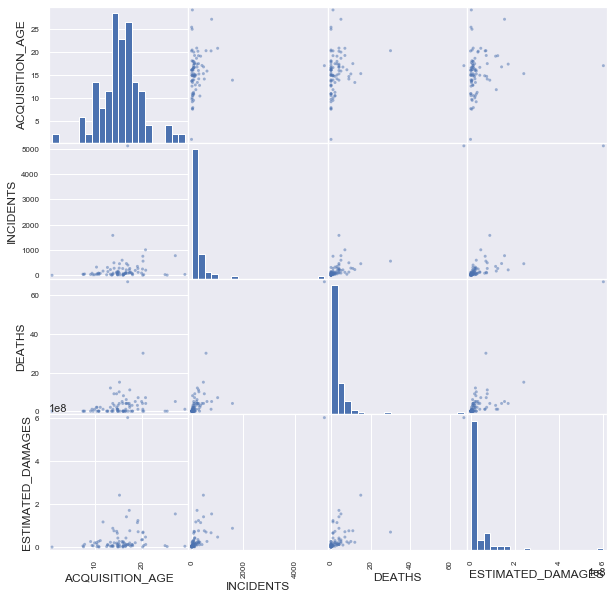

In [108]:
# Next, the age of the firetrucks with the fire incident statistics
pd.plotting.scatter_matrix(merged_firetruck[['ACQUISITION_AGE', 'INCIDENTS', 'DEATHS', 'ESTIMATED_DAMAGES']],
                           alpha=0.5, figsize=(10,10), hist_kwds={'bins': 20})
plt.show()

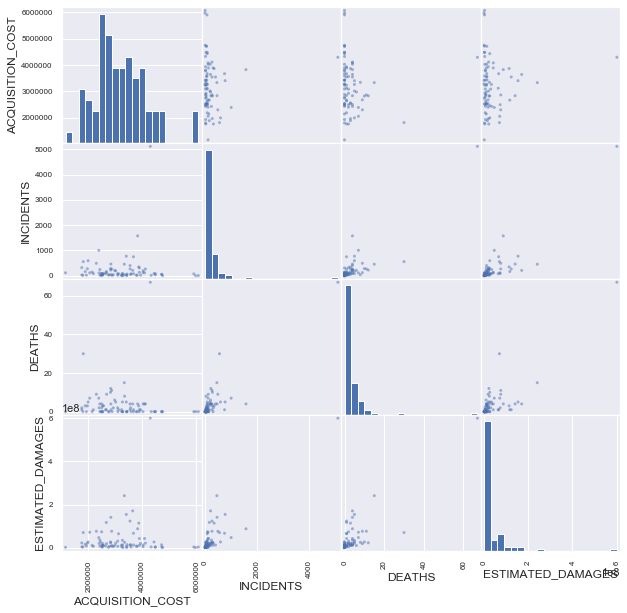

In [109]:
# Lastly, the cost of the firetrucks with the fire incident statistics
pd.plotting.scatter_matrix(merged_firetruck[['ACQUISITION_COST', 'INCIDENTS', 'DEATHS', 'ESTIMATED_DAMAGES']],
                           alpha=0.5, figsize=(10,10), hist_kwds={'bins': 20})
plt.show()

### Findings (Firetruck Data vs Fire Incident Data)
Lorem ipsum

In [110]:
# Before merging IRA dataset with df_2016, we must fix the naming for the provinces
provinces_df = df['PROVINCE_FIRE_DISTRICT'].tolist()
provinces_df3 = df3['PROVINCE'].unique().tolist()
tofix = list(set(provinces_df3)-set(provinces_df)) + ["/////"] + list(set(provinces_df)-set(provinces_df3))
print(tofix)

# Findings:
# We can merge cases like Agusan del Norte and Agusan Del Norte (they differ in one character)
df3.loc[df3['PROVINCE'] == 'Zamboanga Del Sur', 'PROVINCE'] = 'Zamboanga del Sur'
df3.loc[df3['PROVINCE'] == 'Zamboanga Del Norte', 'PROVINCE'] = 'Zamboanga del Norte'
df3.loc[df3['PROVINCE'] == 'Agusan Del Sur', 'PROVINCE'] = 'Agusan del Sur'
df3.loc[df3['PROVINCE'] == 'Agusan Del Norte', 'PROVINCE'] = 'Agusan del Norte'
df3.loc[df3['PROVINCE'] == 'Lanao Del Sur', 'PROVINCE'] = 'Lanao del Sur'
df3.loc[df3['PROVINCE'] == 'Lanao Del Norte', 'PROVINCE'] = 'Lanao del Norte'
df3.loc[df3['PROVINCE'] == 'Davao Del Sur', 'PROVINCE'] = 'Davao del Sur'
df3.loc[df3['PROVINCE'] == 'Davao Del Norte', 'PROVINCE'] = 'Davao del Norte'
df3.loc[df3['PROVINCE'] == 'Surigao Del Sur', 'PROVINCE'] = 'Surigao del Sur'
df3.loc[df3['PROVINCE'] == 'Surigao Del Norte', 'PROVINCE'] = 'Surigao del Norte'
df3.loc[df3['PROVINCE'] == 'Western Samar (Samar)', 'PROVINCE'] = 'Samar'

provinces_df = df['PROVINCE_FIRE_DISTRICT'].tolist()
provinces_df3 = df3['PROVINCE'].unique().tolist()
tofix = list(set(provinces_df3)-set(provinces_df)) + ["/////"] + list(set(provinces_df)-set(provinces_df3))
print(tofix)

['Surigao Del Norte', 'Davao Del Norte', 'Davao Del Sur', 'Lanao Del Norte', 'Zamboanga Del Sur', 'Surigao Del Sur', 'Agusan Del Norte', 'Lanao Del Sur', 'Western Samar (Samar)', 'Zamboanga Del Norte', 'Agusan Del Sur', '/////', 'Metropolitan Manila', 'Davao Occidental', 'Surigao del Sur', 'Lanao del Sur', 'Agusan del Sur', 'Samar', 'Zamboanga del Sur', 'Zamboanga del Norte', 'Davao del Norte', 'Lanao del Norte', 'Surigao del Norte', 'Davao del Sur', 'Agusan del Norte']
['/////', 'Metropolitan Manila', 'Davao Occidental']


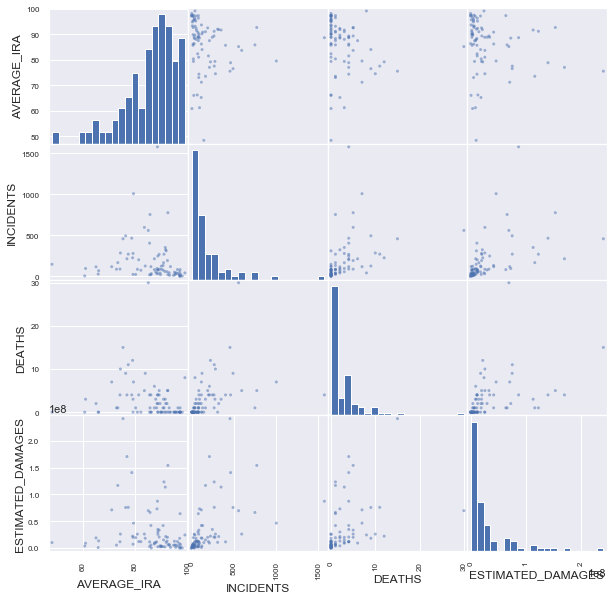

In [111]:
# We make a new IRA dataframe that contains only the provinces and the average IRA from 2009-2014
df3_province = df3[['PROVINCE']].copy()
df3_province['AVERAGE_IRA'] = df3.loc[: , '2009':'2014'].mean(axis=1)

# Now we can merge IRA with the df_2016
merged_ira = df_2016.merge(df3_province,left_on='PROVINCE_FIRE_DISTRICT',right_on='PROVINCE')

# We now use scatterplot visualizations to observe possible correlations between 
# IRA and fire incident statistics
pd.plotting.scatter_matrix(merged_ira[['AVERAGE_IRA', 'INCIDENTS', 'DEATHS', 'ESTIMATED_DAMAGES']],
                           alpha=0.5, figsize=(10,10), hist_kwds={'bins': 20})
plt.show()

### Findings (IRA Data vs Fire Incident Data)
Lorem ipsum

## Inferential Statistics
To confirm our observed inferences, we will be performing statistical tests to confirm any possible correlations between the variables.

In [ ]:
# Code here

## One more thing we can do (maybe the stepwise choochoo?)

In [ ]:
# Code here